<a href="https://colab.research.google.com/github/limshaocong/analyticsEdge/blob/main/Prediction_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [121]:
suppressMessages(library(tidyverse)) # generic must have package
library(dplyr)
library(ggplot2) # plotting package
library(lubridate) # easy comprehension of dates from string to correct datetime format
library(data.table)
library(purrr) # reduce
if("caret" %in% rownames(installed.packages()) == FALSE) {install.packages("caret")}
library(caret)
if("psych" %in% rownames(installed.packages()) == FALSE) {install.packages("psych")}
library(psych) # unscaling
if("padr" %in% rownames(installed.packages()) == FALSE) {install.packages("padr")}
library(padr)
if("janitor" %in% rownames(installed.packages()) == FALSE) {install.packages("janitor")}
library(janitor)

options(repr.plot.width = 9,
        repr.plot.height = 6,
        repr.plot.pointsize = 20)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘future.apply’, ‘progressr’, ‘numDeriv’, ‘SQUAREM’, ‘lava’, ‘prodlim’, ‘proxy’, ‘iterators’, ‘gower’, ‘ipred’, ‘timeDate’, ‘e1071’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’


Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift




In [5]:
# Functions to pull data

git.path = "https://raw.githubusercontent.com/limshaocong/analyticsEdge/main/Datasets/"

# Prices
# Source: CRSP

price.path = "CRSP_WRDS/crsp_daily_stock_price_2020.csv"

get.prices <- function(tickerlist) {

  path = paste0(git.path, price.path)

  df = read.csv(path) %>%
    filter(ticker %in% tickerlist) %>%
    mutate(date = ymd(date)) %>%
    rename(low = BIDLO,
          high = ASKHI,
          open = OPENPRC,
          close = PRC,
          vol = VOL,
          Ntrades = NUMTRD) %>%
    select(ticker, date, open, close, high, low, vol, Ntrades) %>%
    mutate(change = close - open,
          dayspread = high - low,
          averagetrade = vol/Ntrades)
}

# Twitter Sentiment Analysis
# Source: Open source
# Scrapped by snscrape
# Sentiment Analysis by BERT - zer0-shot, multilingual, sentiment model

twtr.path = "Imputed/twitter_sa.csv"

get.twitter.sa <- function (tickerlist){
  path = paste0(git.path, twtr.path)
  
  df = read.csv(path) %>%
    filter(ticker %in% tickerlist) %>%
    mutate(date = as.Date(date, format = "%m/%d/%y")) %>%
    rename(twtrmentions = mentions)
}

# r/wsb Sentiment Analysis
# Source: Quiver Quant
# Sentiment based on VADER sentiment

wsb.path = "Imputed/wsb_imputed_min0.csv"

get.wsb.sa <- function(tickerlist){

  path = paste0(git.path, wsb.path)

  df = read.csv(path) %>%
    filter(Ticker %in% tickerlist) %>%
    mutate(date = ymd(Date)) %>%
    pad(start_val = as.Date('2020-01-01'), end_val = as.Date('2020-12-31')) %>%
    select(Ticker, Date, Mentions, log10Mentions, Sentiment) %>%
    rename(wsbsentiment = Sentiment,
          wsbmentions = Mentions,
          wsblog10mentions = log10Mentions) %>%
    rename_with(tolower)
}

# News Sentiment - Dow Jones + Global Press

pr.path = "Imputed/rp_imputed_min1000.csv"

get.news.sa <- function(tickerlist){

  path = paste0(git.path, pr.path)

  df = read.csv(path) %>%
    filter(Date >= as.Date("2020-01-01") & Date <= as.Date("2020-12-31")) %>%
    filter(ticker %in% tickerlist) %>%
    mutate(date = ymd(Date)) %>%
    rowwise() %>%
    mutate(newssentiment = mean(DJ_mean_ess * DJ_news_instance, PR_mean_ess * PR_news_instance)/All_news_instance) %>%
    replace(is.na(.), 0) %>%
    mutate(newssentiment = (newssentiment-50)/100) %>%
    select(ticker, Date, All_news_instance, newssentiment, log10Allmentions) %>%
    rename(newsmentions = All_news_instance,
          newslog10mentions = log10Allmentions) %>%
    rename_with(tolower)
}

# Compile all data
# Left join to prices df retaining only trading days

get.all.data <- function(tickerlist) {

  prices = get.prices(tickerlist)
  prices$date = as.Date(prices$date)

  wsb.sa = get.wsb.sa(tickerlist)
  wsb.sa$date = as.Date(wsb.sa$date)

  news.sa = get.news.sa(tickerlist)
  news.sa$date = as.Date(news.sa$date)

  twitter.sa = get.twitter.sa(tickerlist)
  twitter.sa$date = as.Date(twitter.sa$date)

  df = list(prices, wsb.sa, news.sa, twitter.sa) %>%
            reduce(left_join, by = c("ticker", "date"))
}

In [128]:
tickerlist = list("AAPL", "TSLA", "MSFT")

imported_df = get.all.data(tickerlist) %>%
  arrange(ticker, date)

pad applied on the interval: day



# **(Slight) Feature Engineering**

In [129]:
# Add in target variable

df = imported_df %>%
  group_by(ticker) %>%
  mutate(target = lead(close, n = 1, default = NA)) %>% # target using by taking the $close of the next period
  mutate(prevclose1 = lag(close, n = 1, default = NA), # additional variables by lagging earlier $close
         prevclose2 = lag(close, n = 2, default = NA), # in log2 scale, kaggle trick
         prevclose4 = lag(close, n = 4, default = NA),
         prevclose8 = lag(close, n = 8, default = NA)) %>%
  mutate(prevwsbsentiment1 = lag(wsbsentiment, n = 1, default = NA), # additional variables by lagging earlier $wsbsentiment
         prevwsbsentiment2 = lag(wsbsentiment, n = 2, default = NA), # in log2 scale, kaggle trick
         prevwsbsentiment4 = lag(wsbsentiment, n = 4, default = NA),
         prevwsbsentiment8 = lag(wsbsentiment, n = 8, default = NA)) %>%
  mutate(prevnewssentiment1 = lag(newssentiment, n = 1, default = NA), # additional variables by lagging earlier $newssentiment
         prevnewssentiment2 = lag(newssentiment, n = 2, default = NA), # in log2 scale, kaggle trick
         prevnewssentiment4 = lag(newssentiment, n = 4, default = NA),
         prevnewssentiment8 = lag(newssentiment, n = 8, default = NA)) %>%
  mutate(prevtwtrsentiment1 = lag(twtrsentiment, n = 1, default = NA), # additional variables by lagging earlier $twtrsentiment
         prevtwtrsentiment2 = lag(twtrsentiment, n = 2, default = NA), # in log2 scale, kaggle trick
         prevtwtrsentiment4 = lag(twtrsentiment, n = 4, default = NA),
         prevtwtrsentiment8 = lag(twtrsentiment, n = 8, default = NA)) %>%
  na.omit %>%
  as.data.frame()

In [130]:
# Do scaling of all variables
# Retain means and sd for unscaling of data

scaling.mean = colMeans(df[sapply(df, is.numeric)])
scaling.sd = sapply(df[sapply(df, is.numeric)], sd)

df[map_lgl(df, is.numeric)] = df %>%
                              select(is.numeric) %>%
                              scale(center = scaling.mean, scale = scaling.sd)

In [131]:
# One-hot encoding for ticker

dummy = dummyVars(" ~ .", data = df)
df = data.frame(predict(dummy, newdata = df))

# **Train-Test Split**


*   Rework with sliding window or expanding window



In [138]:
# Train-test split
split = sort(sample(nrow(df), nrow(df)*.8))
train = df[split,]
test = df[-split,]

# **Model Building and Selection**

In [151]:
library(rpart)
if("rpart.plot" %in% rownames(installed.packages()) == FALSE) {install.packages("rpart.plot")}
library(rpart.plot)
if("Metrics" %in% rownames(installed.packages()) == FALSE) {install.packages("Metrics")}
library(Metrics)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘Metrics’


The following objects are masked from ‘package:caret’:

    precision, recall




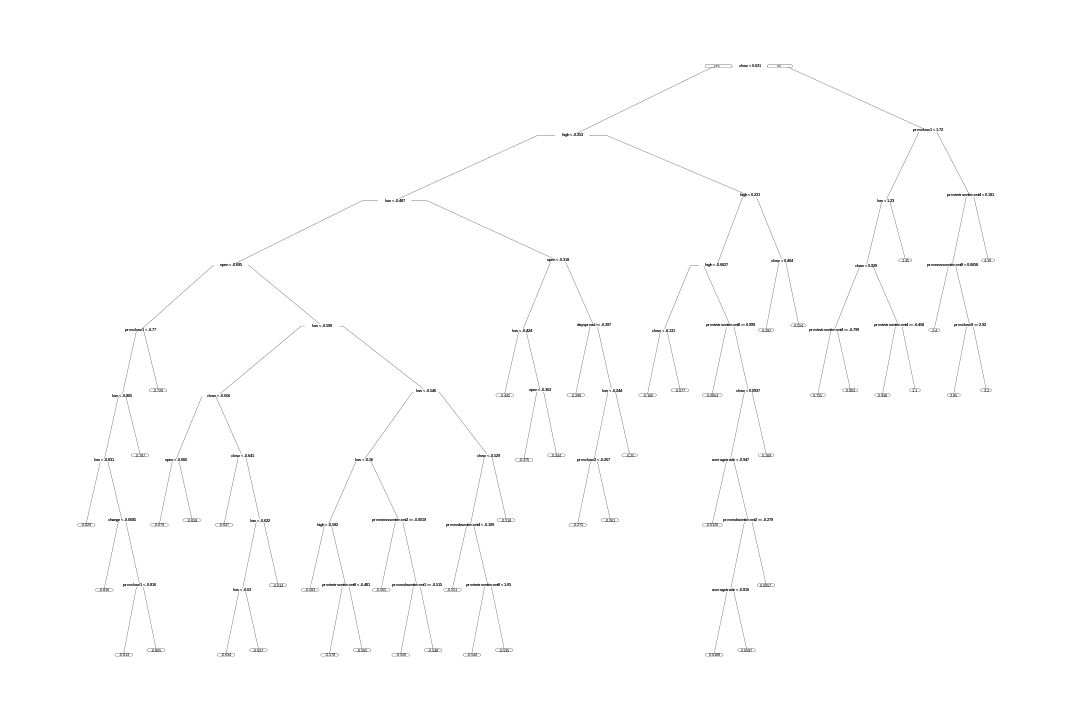

In [145]:
cart.mod = rpart(target ~ . - date,
                data = train,
                cp = 0.0000000001)
prp(cart.mod, digits = 3, tweak = 1)

In [152]:
test$pred = predict(object = cart.mod, newdata = test)


rmse(test$pred, test$target)

[1] 0.09501733